In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
from os.path import basename, isfile, join, splitext
from shutil import copy2

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from insightface_func.face_detect_crop_single import Face_detect_crop
from models.models import create_model
from options.test_options import TestOptions
from util.videoswap import video_swap

model, app = None, None
transformer_Arcface = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


opt = TestOptions()
opt.initialize()
opt.parser.add_argument('-f')  # dummy arg to avoid bug
opt = opt.parse()
opt.Arc_path = './arcface_model/arcface_checkpoint.tar'
opt.isTrain = False
torch.nn.Module.dump_patches = True
global model
model = create_model(opt)
model.eval()
global app
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id=0, det_thresh=0.6, det_size=(256, 256))

------------ Options -------------
gpu_ids: [0]
isTrain: False
target_dict: {'name': 'people', 'gpu_ids': '0', 'checkpoints_dir': './checkpoints', 'model': 'pix2pixHD', 'norm': 'batch', 'use_dropout': False, 'data_type': 32, 'verbose': False, 'fp16': False, 'local_rank': 0, 'isTrain': True, 'batchSize': 8, 'loadSize': 1024, 'fineSize': 512, 'label_nc': 0, 'input_nc': 3, 'output_nc': 3, 'dataroot': './datasets/cityscapes/', 'resize_or_crop': 'scale_width', 'serial_batches': False, 'no_flip': False, 'nThreads': 2, 'max_dataset_size': inf, 'display_winsize': 512, 'tf_log': False, 'netG': 'global', 'latent_size': 512, 'ngf': 64, 'n_downsample_global': 3, 'n_blocks_global': 6, 'n_blocks_local': 3, 'n_local_enhancers': 1, 'niter_fix_global': 0, 'no_instance': False, 'instance_feat': False, 'label_feat': False, 'feat_num': 3, 'load_features': False, 'n_downsample_E': 4, 'nef': 16, 'n_clusters': 10, 'image_size': 224, 'norm_G': 'spectralspadesyncbatch3x3', 'semantic_nc': 3, 'ntest': inf, 'resu

In [3]:
source = '../reference_videos/0.jpg'
target = '../reference_videos/test_video_07.mp4'
result_dir='./output'
crop_size=224


assert isfile(source), f'Can\'t find source at {source}'
assert isfile(target), f'Can\'t find target at {target}'
output_filename = f'infer-{splitext(basename(source))[0]}-{splitext(basename(target))[0]}.mp4'
output_path = join(result_dir, output_filename)

assert model is not None
assert app is not None

img_a_whole = cv2.imread(source)
img_a_align_crop, _ = app.get(img_a_whole, crop_size)
# if img_a_align_crop is None:
#     copy2(target, output_path)
#     return output_path
img_a_align_crop_pil = Image.fromarray(
    cv2.cvtColor(img_a_align_crop[0], cv2.COLOR_BGR2RGB))
img_a = transformer_Arcface(img_a_align_crop_pil)
img_id = img_a.view(-1, img_a.shape[0], img_a.shape[1], img_a.shape[2])
img_id = img_id.cuda()

img_id_downsample = F.interpolate(img_id, scale_factor=0.5)
latend_id = model.netArc(img_id_downsample)
latend_id = latend_id.detach().to('cpu')
latend_id = latend_id / np.linalg.norm(latend_id, axis=1, keepdims=True)
latend_id = latend_id.to('cuda')

2021-07-13 22:45:08.935910860 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,10} does not match actual shape of {128,10} for output 500
2021-07-13 22:45:08.935970558 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,4} does not match actual shape of {128,4} for output 497
2021-07-13 22:45:08.936001957 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,1} does not match actual shape of {128,1} for output 494
2021-07-13 22:45:08.936600137 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {3200,10} does not match actual shape of {512,10} for output 477
2021-07-13 22:45:08.936663835 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {3200,4} does not match actual shape of {512,4} for output 474
2021-07-13 22:45:08.936723533 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expec

In [4]:
import os
import shutil
import subprocess
from datetime import datetime
from os.path import basename, dirname, exists, isfile, join, normpath, splitext
from time import gmtime, perf_counter, strftime

import cv2
import numpy as np
import torch
from tqdm import tqdm

from util.videoswap import timer, lower_resolution, extract_audio, get_frames_n, _totensor

In [5]:
from face_seg.nets.MobileNetV2_unet import MobileNetV2_unet

seg_model = MobileNetV2_unet(None).to('cuda')
state_dict = torch.load('face_seg/checkpoints/model.pt', map_location='cpu')
seg_model.load_state_dict(state_dict)
seg_model.eval();

=> Swapping face in "../reference_videos/test_video_07.mp4"...
=> Extracting audio from video "test_video_07.mp4"...
> Time elapsed on `Extracting audio`: 00:00:00 (2021-07-13 23:41:28.841691).
0it [00:00, ?it/s]2021-07-13 23:41:29.252251179 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,10} does not match actual shape of {128,10} for output 500
2021-07-13 23:41:29.252326677 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,4} does not match actual shape of {128,4} for output 497
2021-07-13 23:41:29.252356076 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {800,1} does not match actual shape of {128,1} for output 494
2021-07-13 23:41:29.252956657 [W:onnxruntime:, execution_frame.cc:721 VerifyOutputSizes] Expected shape from model of {3200,10} does not match actual shape of {512,10} for output 477
2021-07-13 23:41:29.253027054 [W:onnxruntime:, execution_frame.

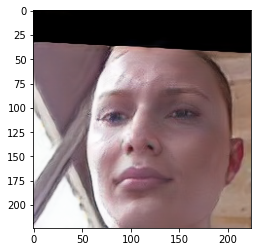

swaped_img
(224, 224) [  0. 255.] <class 'numpy.ndarray'>
[[   5.02779308    0.26296989  129.43721179]
 [  -0.26296989    5.02779308 -161.78765282]]


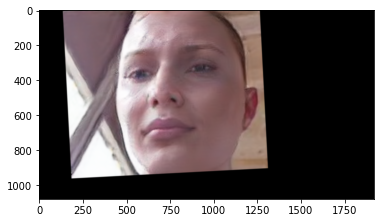

target_image


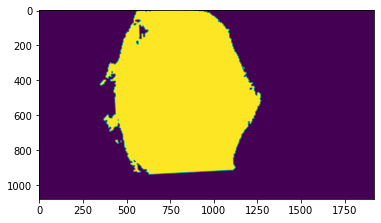

img_white


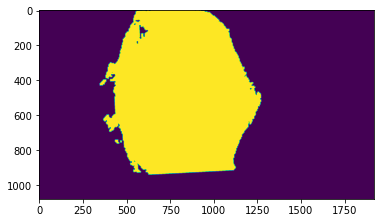

img_white


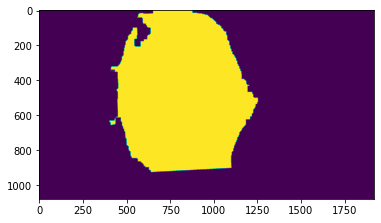

img_mask


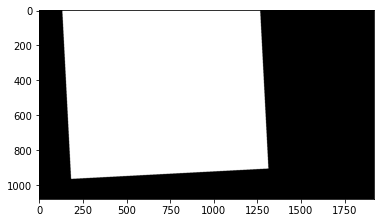

target_image


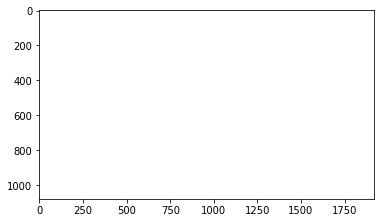

img


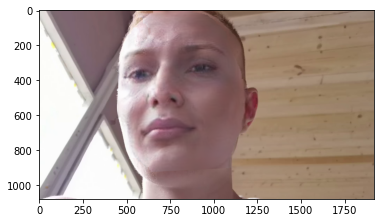

1it [00:04,  4.74s/it]final_img-RGB



In [30]:
import matplotlib.pyplot as plt
from scipy.special import expit


def reverse2wholeimage(swaped_imgs, mats, crop_size, oriimg, save_path=''):
    target_image_list = []
    img_mask_list = []
    for swaped_img, mat in zip(swaped_imgs, mats):
        seg_mask_logits = seg_model(swaped_img.unsqueeze(0))
        seg_mask = seg_mask_logits.cpu().detach().numpy().squeeze()
        seg_mask  = seg_mask.transpose((1, 2, 0))
        # plt.imshow(seg_mask); plt.show(); print('seg_mask') ###

        # sigm_ = expit(seg_mask[:, :, 1])
        # print(sigm_.shape, sigm_.min(), sigm_.max())
        # plt.imshow(sigm_); plt.show(); print('seg_mask') ###
        # plt.imshow(sigm_ > 0.5); plt.show(); print('seg_mask 0.5') ###
        # plt.imshow(sigm_ > 0.6); plt.show(); print('seg_mask 0.6') ###
        # plt.imshow(sigm_ > 0.7); plt.show(); print('seg_mask 0.7') ###
        # plt.imshow(sigm_ > 0.8); plt.show(); print('seg_mask 0.8') ###

        seg_mask = np.argmax(seg_mask, axis=2) == 1

        swaped_img = swaped_img.cpu().detach().numpy().transpose((1, 2, 0))
        plt.imshow(swaped_img); plt.show(); print('swaped_img') ###
        cv2.imwrite(splitext(save_path)[0] + '_' + splitext(save_path)[1], cv2.cvtColor(swaped_img * 255, cv2.COLOR_BGR2RGB))

        img_white = seg_mask * 255
        img_white = np.array(img_white, dtype=float)
        print(img_white.shape, np.unique(img_white), type(img_white))

        mat_rev = np.zeros([2, 3])
        div1 = mat[0][0]*mat[1][1]-mat[0][1]*mat[1][0]
        mat_rev[0][0] = mat[1][1]/div1
        mat_rev[0][1] = -mat[0][1]/div1
        mat_rev[0][2] = -(mat[0][2]*mat[1][1]-mat[0][1]*mat[1][2])/div1
        div2 = mat[0][1]*mat[1][0]-mat[0][0]*mat[1][1]
        mat_rev[1][0] = mat[1][0]/div2
        mat_rev[1][1] = -mat[0][0]/div2
        mat_rev[1][2] = -(mat[0][2]*mat[1][0]-mat[0][0]*mat[1][2])/div2

        print(mat_rev)

        orisize = (oriimg.shape[1], oriimg.shape[0])
        target_image = cv2.warpAffine(swaped_img, mat_rev, orisize)
        plt.imshow(target_image); plt.show(); print('target_image') ###
        img_white = cv2.warpAffine(img_white, mat_rev, orisize)
        plt.imshow(img_white); plt.show(); print('img_white') ###

        img_white[img_white > 20] = 255
        plt.imshow(img_white); plt.show(); print('img_white') ###

        img_mask = img_white

        kernel = np.ones((10, 10), np.uint8)
        img_mask = cv2.erode(img_mask, kernel, iterations=1)
        plt.imshow(img_mask); plt.show(); print('img_mask') ###

        img_mask /= 255

        img_mask = np.reshape(img_mask, [img_mask.shape[0], img_mask.shape[1], 1])
        target_image = np.array(target_image, dtype=np.float64)[..., ::-1] * 255
        plt.imshow(target_image); plt.show(); print('target_image') ###

        img_mask_list.append(img_mask)
        target_image_list.append(target_image)

    img = np.array(oriimg, dtype=np.float64)
    for img_mask, target_image in zip(img_mask_list, target_image_list):
        img = img_mask * target_image + (1-img_mask) * img
    plt.imshow(img); plt.show(); print('img') ###

    final_img = img.astype(np.uint8)
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)); plt.show(); print('final_img-RGB') ###

    cv2.imwrite(save_path, final_img)


video_path = target
temp_results_dir='./temp_results'
swap_model = model
detect_model = app
id_veсtor = latend_id

lower_resolution(video_path)
print(f'=> Swapping face in "{video_path}"...')
if exists(temp_results_dir):
    shutil.rmtree(temp_results_dir)
os.makedirs(temp_results_dir)

audio_path = join(temp_results_dir, splitext(basename(video_path))[0] + '.wav')
extract_audio(video_path, audio_path)

frame_count = get_frames_n(video_path)

video = cv2.VideoCapture(video_path)
fps = video.get(cv2.CAP_PROP_FPS)

for i, frame_index in tqdm(enumerate(range(frame_count))): 
    if i > 0:
        break
    _, frame = video.read()
    detect_results = detect_model.get(frame, crop_size)     

    if detect_results is not None:
        frame_align_crop_list = detect_results[0]
        frame_mat_list = detect_results[1]
        swap_result_list = []

        for frame_align_crop in frame_align_crop_list:
            frame_align_crop_tensor = _totensor(cv2.cvtColor(frame_align_crop,cv2.COLOR_BGR2RGB))[None,...].cuda()

            swap_result = swap_model(None, frame_align_crop_tensor, id_veсtor, None, True)[0]
            swap_result_list.append(swap_result)
        reverse2wholeimage(swap_result_list, frame_mat_list, crop_size, frame, join(temp_results_dir, 'frame_{:0>7d}.jpg'.format(frame_index)))
    else:
        frame = frame.astype(np.uint8)
        cv2.imwrite(join(temp_results_dir, 'frame_{:0>7d}.jpg'.format(frame_index)), frame)

# video.release()
# create_video(save_path, audio_path, temp_results_dir, fps)
# shutil.rmtree(temp_results_dir)